In [1]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import mra 
import selector as se

In [2]:
plt.rcParams['text.usetex'] = True
np.random.seed(123)

# Create parameters

In [3]:
rho = 1.
num_points = 10
eps_sublevel = percent = 0.1

alpha = 1 # proximal term coefficient

num_agents = num_packages = 200
num_fcs = 50

filename = "local_ap_N%d_%.2f_n%d_m%d"%(num_points, eps_sublevel, num_agents, num_fcs)

In [4]:
econ, A_ineq, b_ineq = mra.ap_data(num_packages, num_fcs)

In [5]:
b_norm = np.linalg.norm(b_ineq)

# CVXPY centralized solution

In [6]:
true_xp, true_xf, true_f, true_lamb, true_prob = mra.assignment_problem_milp_solution(num_packages, num_fcs, econ,  integer=False)
print(f"{true_f=}")

true_f=-90.29596235198767


In [7]:
(true_lamb.max() - true_lamb.min()) / true_lamb.max()

0.12754546028411598

In [8]:
true_lamb.shape, true_xp.size + true_xf.size

((50,), 10050)

In [9]:
fun_agents_eps = []
fun_agents_noisy_y = []

for i in range(num_packages):
    fun_agents_eps += [lambda lamb_k, K, i=i: mra.cvx_package_agent_query_multiple_actions(lamb_k, i, num_fcs,
                                                                                  econ, eps_sublevel=eps_sublevel, K=K,  return_best=True)]
    fun_agents_noisy_y += [lambda lamb_k, K, i=i: mra.cvx_package_agent_query_multiple_actions_noisy_prices(lamb_k, i, num_fcs,
                                                                                  econ, percent=percent, K=K,  return_best=True)]
 
for i in range(num_packages, num_packages+num_fcs):
    fun_agents_eps += [lambda lamb_k, K, i=i: mra.fc_agent_query_multiple_actions(lamb_k, i-num_packages, 
                                                                          econ, eps_sublevel=eps_sublevel, K=K, return_best=True)]
    fun_agents_noisy_y += [lambda lamb_k, K, i=i: mra.fc_agent_query_multiple_actions_noisy_prices(lamb_k, i-num_packages, 
                                                                          econ, percent=percent, K=K, return_best=True)]


fun_obj_val = lambda x_k: mra.assignment_problem_obj_val(x_k, num_packages, num_fcs, econ, integer=False)

# Localization

In [10]:
price_max = 3 * true_lamb.max()
price_min = (1./3) * true_lamb.min()
K_i = num_points
N = num_agents
primal_var_size = A_ineq.shape[1]

In [11]:
all_results_eps, lamb_k_eps, _, x_k, _, mra_xk_eps  = mra.price_localization_primal_recovery(fun_agents_eps, fun_obj_val, primal_var_size, A_ineq=A_ineq, b_ineq=b_ineq, 
                                                            price_max=price_max, price_min=price_min, alpha=alpha, relaxed=True, 
                                                            postprocessing=1, K_i=K_i, num_iters=100, 
                                                            method="accpm_l2", true_f=true_f, print_freq=50, eps_lamb=1e-28,
                                                            res_type="primal_compl_slack", history=1)


all_results_noisy_y, lamb_k_eps, _, x_k, _, mra_xk_noisy_y  = mra.price_localization_primal_recovery(fun_agents_noisy_y, fun_obj_val, primal_var_size, 
                                                                                                      A_ineq=A_ineq, b_ineq=b_ineq, 
                                                            price_max=price_max, price_min=price_min, alpha=alpha, relaxed=True, 
                                                            postprocessing=1, K_i=K_i, num_iters=100, 
                                                            method="accpm_l2", true_f=true_f, print_freq=50, eps_lamb=1e-28,
                                                            res_type="primal_compl_slack", history=1)

/Users/tepars/Documents/postdoc/mra_precovery/mra/localization_prim_rec.py:86: RuntimeWarning: divide by zero encountered in scalar divide
  lamb_rel_diff = np.linalg.norm(lamb_k - lamb_prev) / np.linalg.norm(lamb_prev)


epoch=0, f_subopt_xk=1.3026E+00,  f_subopt_mra=1.0444E+00,  viol_xk=1.3706E+02, viol_mra=1.0278E+02, lamb_rel_diff=INF
epoch=15, f_subopt_xk=2.1195E-02,  f_subopt_mra=4.3804E-02,  viol_xk=7.8628E+01, viol_mra=8.7581E-10, lamb_rel_diff=5.8849E-02
terminate with lamb_rel_diff=0.05884912861813359
epoch=0, f_subopt_xk=1.3026E+00,  f_subopt_mra=1.2548E+00,  viol_xk=1.3706E+02, viol_mra=1.3256E+02, lamb_rel_diff=INF
epoch=50, f_subopt_xk=9.5050E-03,  f_subopt_mra=8.7611E-03,  viol_xk=7.1921E+01, viol_mra=9.7299E+00, lamb_rel_diff=5.4798E-02
epoch=71, f_subopt_xk=9.4849E-03,  f_subopt_mra=8.8028E-03,  viol_xk=6.2050E+01, viol_mra=9.1464E-10, lamb_rel_diff=4.7269E-02
terminate with lamb_rel_diff=0.04726876555948822


In [9]:
if len(all_results_noisy_y["subopt_xk"]) > len(all_results_eps["subopt_xk"]):
    all_res = all_results_noisy_y
else:
    all_res = all_results_eps

In [17]:
T = 100
idx_xk = np.argmin(np.array(all_res["viol_primal_xk"])[:T])
idx_paverage = np.argmin(np.array(all_res["viol_primal_paver_xk"])[:T])
idx_noisy_y = np.where(np.array(all_results_noisy_y["viol_primal_mra_xk"][:T]) < 1e-8)[0][1]
idx_eps = 15#np.where(np.array(all_results_eps["viol_primal_mra_xk"][:T]) < 1e-8)[0][1]

print(f"{idx_xk=}, {idx_eps=}, {idx_noisy_y=}, {idx_paverage=}")

print("xk", (np.abs(np.array(all_res["f_xk"]) - true_f)/np.abs(true_f))[idx_xk],
    "sub_eps", (np.abs(np.array(all_results_eps["f_mra_xk"]) - true_f)/np.abs(true_f))[idx_eps],
    "noisy_y", (np.abs(np.array(all_results_noisy_y["f_mra_xk"]) - true_f)/np.abs(true_f))[idx_noisy_y],
    "proj", ((np.abs(np.array(all_res["f_proj_xk"]) - true_f))/np.abs(true_f)).min(),
    "paverage", (np.abs(np.array(all_res["f_paver_xk"]) - true_f)/np.abs(true_f))[idx_paverage])

print("xk", np.array(all_res["viol_primal_xk"])[idx_xk],
      "sub_eps", all_results_eps["viol_primal_mra_xk"][idx_eps],
      "noisy_y", all_results_noisy_y["viol_primal_mra_xk"][idx_noisy_y],
      "paverage", np.array(all_res["viol_primal_paver_xk"])[idx_paverage])

idx_xk=0, idx_eps=15, idx_noisy_y=71, idx_paverage=0
xk 1.3025673032620098 sub_eps 0.04380399586119079 noisy_y 0.008802799031680294 proj 0.7852906092705896 paverage 1.3025673032620098
xk 0.0 sub_eps 5.622964680679354e-10 noisy_y 5.587214359272697e-10 paverage 0.0


In [ ]:
import pickle

with open(f"../results/{filename}_dict.pkl", "wb") as file:
    pickle.dump({"eps":all_results_eps, "noisy_y":all_results_noisy_y}, file)

# res["eps"].keys()

In [7]:
import pickle

with open(f"../results/{filename}_dict.pkl", "rb") as file:
    res = pickle.load(file)

all_results_eps, all_results_noisy_y = res["eps"], res["noisy_y"]
T = 100

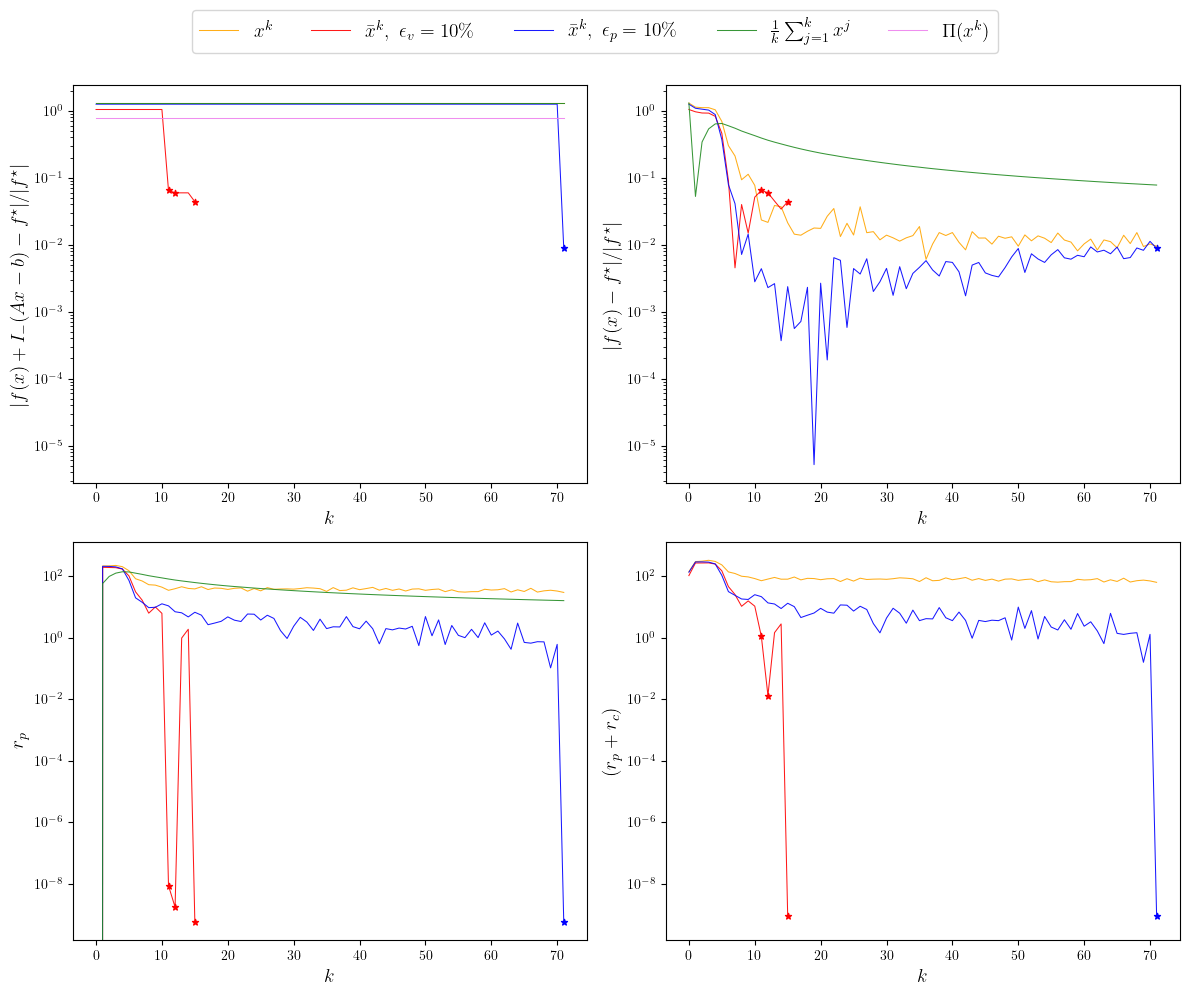

In [8]:
mra.plot_all_methods_metrics_4x(all_results_eps, all_results_noisy_y, true_f, 
                                b_norm, percent, eps_sublevel, filename, T)